# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
pip install palmerpenguins

In [2]:
# Code Here
from palmerpenguins import load_penguins
import pandas as pd
penguins = load_penguins()
penguins_dummies = pd.get_dummies(penguins, drop_first = False)

penguins_clean = penguins_dummies.dropna()
penguins_clean = penguins_clean.applymap(lambda x: 1 if x is True else (0 if x is False else x))
penguins_clean.head()

/tmp/ipython-input-3331319596.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  penguins_clean = penguins_clean.applymap(lambda x: 1 if x is True else (0 if x is False else x))


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,39.1,18.7,181.0,3750.0,2007,1,0,0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,2007,1,0,0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,2007,1,0,0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,2007,1,0,0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,2007,1,0,0,0,0,1,0,1


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [3]:
# define predictors and target
X = penguins_clean.drop(columns = 'bill_depth_mm')
y = penguins_clean['bill_depth_mm']

In [10]:
#linear model from previous activity
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(
    X[['sex_male', 'flipper_length_mm', 'body_mass_g']],
    y
)

# cross-validated predictions
linear_cv_preds = cross_val_predict(
    linear_model,
    X[['sex_male','flipper_length_mm','body_mass_g']],
    y,
    cv=5
)

# test MSE (CV error)
linear_test_mse = mean_squared_error(y, linear_cv_preds)

# training MSE (fit on all data)
linear_train_preds = linear_model.predict(X[['sex_male','flipper_length_mm','body_mass_g']])
linear_train_mse = mean_squared_error(y, linear_train_preds)

In [11]:
#Knn Model
from sklearn.model_selection import train_test_split



from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid = {"knn__n_neighbors": range(1,31)}

gscv = GridSearchCV(
    knn_pipe,
    param_grid,
    cv = 5,
    scoring = "r2"
)

gscv_fitted = gscv.fit(X, y)

best_k = gscv_fitted.best_estimator_.get_params()["knn__n_neighbors"]
print("Best k =", best_k)

knn_test_preds = gscv_fitted.predict(X)

best_knn = gscv_fitted.best_estimator_

# CV predictions
knn_cv_preds = cross_val_predict(best_knn, X, y, cv=5)

# test MSE
knn_test_mse = mean_squared_error(y, knn_cv_preds)

# training MSE (fit on all data)
best_knn.fit(X, y)
knn_train_preds = best_knn.predict(X)
knn_train_mse = mean_squared_error(y, knn_train_preds)


Best k = 12


In [12]:
# decision tree
from sklearn.tree import DecisionTreeRegressor

# Tree pipeline (no scaler)
tree_pipe = Pipeline([
    ('tree', DecisionTreeRegressor())
])

# Hyperparameter tuning
param_grid_tree = {
    "tree__max_depth": range(1, 21),
}

# Grid search
gscv_tree = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid_tree,
    cv=5,
    scoring="r2"
)

# Fit
gscv_tree_fitted = gscv_tree.fit(X, y)

# Best parameters
print("Best decision tree hyperparameters:", gscv_tree_fitted.best_params_)

# Predictions
tree_test_preds = gscv_tree_fitted.predict(X)

best_tree = gscv_tree_fitted.best_estimator_

# CV predictions
tree_cv_preds = cross_val_predict(best_tree, X, y, cv=5)

# test MSE
tree_test_mse = mean_squared_error(y, tree_cv_preds)

# training MSE
best_tree.fit(X, y)
tree_train_preds = best_tree.predict(X)
tree_train_mse = mean_squared_error(y, tree_train_preds)

Best decision tree hyperparameters: {'tree__max_depth': 2}


In [13]:
import pandas as pd

results_mse = pd.DataFrame({
    "model": ["Linear", "KNN (best k)", "Decision Tree"],
    "flexibility": [1, 2, 3],
    "train_MSE": [linear_train_mse, knn_train_mse, tree_train_mse],
    "test_MSE":  [linear_test_mse,  knn_test_mse,  tree_test_mse]
})

results_mse


,model,flexibility,train_MSE,test_MSE
0,Linear,1,1.349319,1.540459
1,KNN (best k),2,0.558240,0.816696
2,Decision Tree,3,0.700525,3.119615


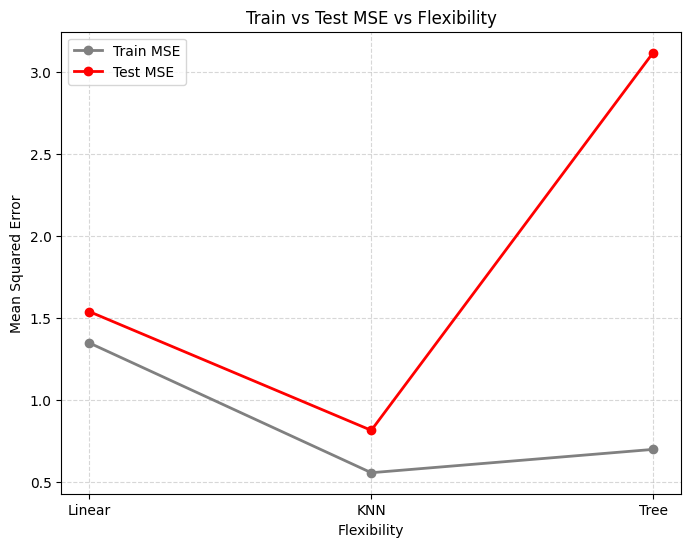

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(results_mse["flexibility"], results_mse["train_MSE"],
         marker='o', color='gray', linewidth=2, label="Train MSE")

plt.plot(results_mse["flexibility"], results_mse["test_MSE"],
         marker='o', color='red', linewidth=2, label="Test MSE")

plt.xticks([1,2,3], ["Linear", "KNN", "Tree"])
plt.xlabel("Flexibility")
plt.ylabel("Mean Squared Error")
plt.title("Train vs Test MSE vs Flexibility")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.show()


According to the graph and train vs test MSE table, the Knn model is the best one.